In [1]:
# https://www.kaggle.com/c/titanic
# joint randomly chosen kernels
import numpy as np  # Mathetimatical Operations
import pandas as pd  # Data manipulation
import random
import time
from sys import getsizeof
# Visualization
import seaborn as sns
import matplotlib.pyplot as plot
# %matplotlib inline

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, classification_report, mean_squared_error, \
    confusion_matrix, f1_score, precision_recall_curve, r2_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
    VotingClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

# Scipy
from scipy.stats import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

# XGBoost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost as xgb

# LightGBM
import lightgbm as lgb

# Datetime
import datetime
import time
from datetime import datetime

# Folium
import folium
from folium import plugins
from folium.plugins import HeatMap

# Image
from IPython.display import Image

# pip install https://github.com/scikit-optimize/scikit-optimize/archive/v0.7.4.zip
# Bayesian Optimizer
from skopt import BayesSearchCV

# Itertools
import itertools

# roc
from sklearn.metrics import roc_curve
from sklearn.utils import resample
# pip install https://github.com/edouardlp/ml-utils/archive/master.zip
# from mlutils.transformers import Preprocessor
from sklearn.feature_extraction import FeatureHasher

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 3
NJOBS = 3
NSPLIT = NJOBS
# TRAINING_SIZE = 100000
# TEST_SIZE = 25000
SEED = round(time.time())
# SEED = 1584353119
random.seed(SEED)

In [3]:
data_train = pd.read_csv('work/titanic_train.csv')
data_test = pd.read_csv('work/titanic_test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
406,407,0,3,"Widegren, Mr. Carl/Charles Peter",male,51.0,0,0,347064,7.7500,NaN,S
349,350,0,3,"Dimic, Mr. Jovan",male,42.0,0,0,315088,8.6625,NaN,S
492,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S


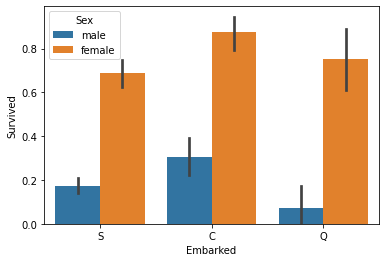

In [4]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);
plot.show()

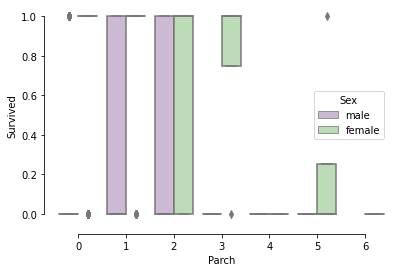

In [5]:
# sns.violinplot(x="Embarked", y="Survived", data=data_train);
sns.boxplot(x="Parch", y="Survived", hue="Sex", data=data_train, palette="PRGn");
sns.despine(offset=10, trim=True)
plot.show()

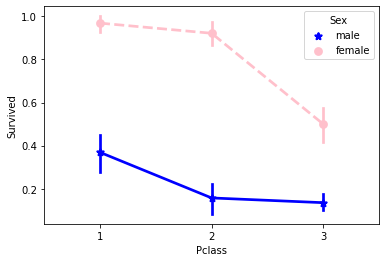

In [6]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);
plot.show()

In [7]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df


def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df


def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df


def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df


def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)


def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df


data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


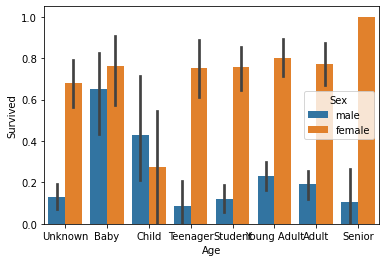

In [8]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);
plot.show()

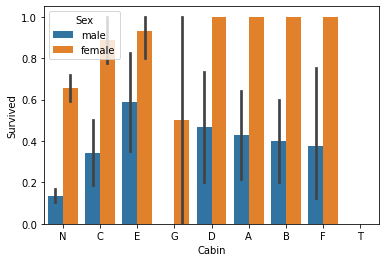

In [9]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);
plot.show()

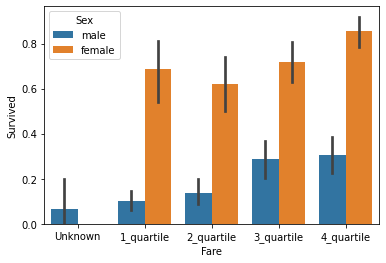

In [10]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);
plot.show()

In [11]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [12]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=SEED)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier.
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9],
              'max_features': ['log2', 'sqrt','auto'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7821229050279329


In [14]:

# https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

run_kfold(clf)
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

Fold 1 accuracy: 0.8222222222222222
Fold 2 accuracy: 0.8426966292134831
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.797752808988764
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.8314606741573034
Fold 7 accuracy: 0.7640449438202247
Fold 8 accuracy: 0.7415730337078652
Fold 9 accuracy: 0.8876404494382022
Fold 10 accuracy: 0.7640449438202247
Mean Accuracy: 0.8058177278401997


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [15]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""

    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)

    # Get current parameters and the best parameters
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = NJOBS,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (1, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 10),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=NSPLIT,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = NJOBS,
    n_iter = ITERATIONS,
    verbose = 0,
    refit = True,
    random_state = SEED
)

# resultxgb = bayes_cv_tuner.fit(X, y, callback=status_print)
resultxgb = bayes_cv_tuner.fit(X_train, y_train, callback=status_print)
print(resultxgb.best_params_)

Model #1
Best ROC-AUC: 0.8508
Best params: OrderedDict([('colsample_bylevel', 0.2812406425781984), ('colsample_bytree', 0.8710792741524772), ('gamma', 4.62439329933301e-07), ('learning_rate', 0.5451860909305293), ('max_delta_step', 12), ('max_depth', 30), ('min_child_weight', 10), ('n_estimators', 72), ('reg_alpha', 0.014073973776031225), ('reg_lambda', 358), ('scale_pos_weight', 437), ('subsample', 0.5640019447375181)])

Model #2
Best ROC-AUC: 0.8508
Best params: OrderedDict([('colsample_bylevel', 0.2812406425781984), ('colsample_bytree', 0.8710792741524772), ('gamma', 4.62439329933301e-07), ('learning_rate', 0.5451860909305293), ('max_delta_step', 12), ('max_depth', 30), ('min_child_weight', 10), ('n_estimators', 72), ('reg_alpha', 0.014073973776031225), ('reg_lambda', 358), ('scale_pos_weight', 437), ('subsample', 0.5640019447375181)])

Model #3
Best ROC-AUC: 0.8508
Best params: OrderedDict([('colsample_bylevel', 0.2812406425781984), ('colsample_bytree', 0.8710792741524772), ('gamma

In [16]:
xgbmodel = XGBClassifier(**resultxgb.best_params_)

xgbmodel.fit(X_train, y_train)
preds_xgb = xgbmodel.predict_proba(X_test)[:, 1]
labels = ['No Apply', 'Apply']
xgb_roc_auc = roc_auc_score(y_test, preds_xgb)

print('The baseline AUC score on the test set is {:.4f}.'.format(xgb_roc_auc))

The baseline AUC score on the test set is 0.8417.


In [17]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        n_jobs = NJOBS,
        objective = 'binary',
        #eval_metric = 'logloss',
        #tree_method='hist',
        boosting_type='gbdt',
        silent=1
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (1, 50),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100)
    },
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=NSPLIT,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = NJOBS,
    n_iter = ITERATIONS,
    verbose = 0,
    refit = True,
    random_state = SEED
)

# resultlgb = bayes_cv_tuner.fit(X, y, callback=status_print)
resultlgb = bayes_cv_tuner.fit(X_train, y_train, callback=status_print)
print(resultlgb.best_params_)

Model #1
Best ROC-AUC: 0.8585
Best params: OrderedDict([('colsample_bytree', 0.2812406425781984), ('learning_rate', 0.5489769236686779), ('max_depth', 16), ('min_child_weight', 4), ('n_estimators', 80), ('reg_alpha', 0.00019863509070312246), ('reg_lambda', 953), ('subsample', 0.4357546959956106)])

Model #2
Best ROC-AUC: 0.8591
Best params: OrderedDict([('colsample_bytree', 0.13738496256035446), ('learning_rate', 0.1468524454118524), ('max_depth', 16), ('min_child_weight', 2), ('n_estimators', 91), ('reg_alpha', 7.734998882143651e-07), ('reg_lambda', 167), ('subsample', 0.5622303960571408)])

Model #3
Best ROC-AUC: 0.8591
Best params: OrderedDict([('colsample_bytree', 0.13738496256035446), ('learning_rate', 0.1468524454118524), ('max_depth', 16), ('min_child_weight', 2), ('n_estimators', 91), ('reg_alpha', 7.734998882143651e-07), ('reg_lambda', 167), ('subsample', 0.5622303960571408)])

OrderedDict([('colsample_bytree', 0.13738496256035446), ('learning_rate', 0.1468524454118524), ('max

In [18]:
Lgbmodel = lgb.LGBMClassifier(**resultlgb.best_params_)

Lgbmodel.fit(X_train, y_train)
preds_lgb = Lgbmodel.predict_proba(X_test)[:, 1]
labels = [0, 1]
lgb_roc_auc = roc_auc_score(y_test, preds_xgb)

print('The baseline AUC score on the test set is {:.4f}.'.format(lgb_roc_auc))

The baseline AUC score on the test set is 0.8417.


In [19]:
# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
        n_jobs = -1
    ),
    search_spaces = {
    'min_samples_split': [3, 5, 8, 10, 20],
    'n_estimators' : [100, 500],
    'max_depth': [3, 5, 8, 10, 15],
    'max_features': [3, 5, 6]
},
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=NSPLIT,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = NJOBS,
    n_iter = ITERATIONS,
    verbose = 0,
    refit = True,
    random_state = SEED
)

resultrf = bayes_cv_tuner.fit(X_train, y_train, callback=status_print)
print(resultrf.best_params_)

Model #1
Best ROC-AUC: 0.8687
Best params: OrderedDict([('max_depth', 5), ('max_features', 6), ('min_samples_split', 5), ('n_estimators', 447)])

Model #2
Best ROC-AUC: 0.8687
Best params: OrderedDict([('max_depth', 5), ('max_features', 6), ('min_samples_split', 5), ('n_estimators', 447)])

Model #3
Best ROC-AUC: 0.8695
Best params: OrderedDict([('max_depth', 8), ('max_features', 3), ('min_samples_split', 20), ('n_estimators', 148)])

OrderedDict([('max_depth', 8), ('max_features', 3), ('min_samples_split', 20), ('n_estimators', 148)])


In [20]:
rfmodel = RandomForestClassifier(**resultrf.best_params_,
            class_weight = "balanced",
            bootstrap = True,
            criterion = 'entropy',
            random_state = SEED
    )

rfmodel.fit(X_train, y_train)
preds_rf = rfmodel.predict_proba(X_test)[:,1]
rf_roc_auc = roc_auc_score(y_test, preds_rf)
print('The baseline score on the test set is {:.4f}.'.format(rf_roc_auc))

The baseline score on the test set is 0.8571.


In [21]:
eclf = VotingClassifier(estimators=[('xgb',xgbmodel),('lgb',Lgbmodel),('rf',rfmodel)], voting='soft', weights=[1,1,1])

eclf.fit(X_train, y_train)
preds_eclf = eclf.predict_proba(X_test)[:,1]

eclf_roc_auc = roc_auc_score(y_test, preds_eclf)

print('The baseline AUC score on the test set is {:.4f}.'.format(eclf_roc_auc))

The baseline AUC score on the test set is 0.8510.


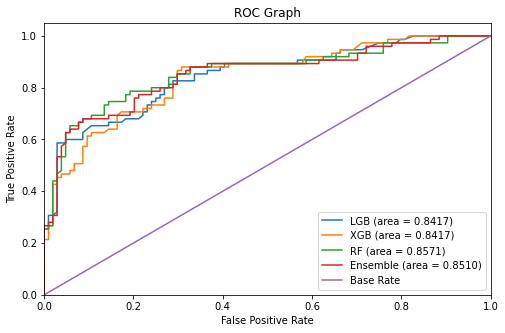

1587823387


In [22]:
lgb_fpr, lgb_tpr, lgb_thresholds = roc_curve(y_test, Lgbmodel.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgbmodel.predict_proba(X_test)[:,1])
eclf_fpr, eclf_tpr, eclf_thresholds = roc_curve(y_test, eclf.predict_proba(X_test)[:,1])

plot.figure(figsize=(8,5))

# Plot LGB Classifier ROC
plot.plot(lgb_fpr, lgb_tpr, label='LGB (area = %0.4f)' % lgb_roc_auc)

# Plot XGB classifier ROC
plot.plot(xgb_fpr, xgb_tpr, label='XGB (area = %0.4f)' % xgb_roc_auc)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rfmodel.predict_proba(X_test)[:,1])
plot.plot(rf_fpr, rf_tpr, label='RF (area = %0.4f)' % rf_roc_auc)
# Plot Ensemble classifier ROC
plot.plot(eclf_fpr, eclf_tpr, label='Ensemble (area = %0.4f)' % eclf_roc_auc)
# Plot Base Rate ROC
plot.plot([0,1], [0,1],label='Base Rate')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('ROC Graph')
plot.legend(loc="lower right")
plot.show()
print(SEED)